<a href="https://colab.research.google.com/github/Geerford/data-science-ipynb/blob/master/Ensemble%20learning/Stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip
!pip install imutils
!pip install opencv-python
!pip install --upgrade scikit-learn==0.23.0

     |████████████████████████████████| 1.5MB 2.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 7.3 MB 2.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


Подключение базовых библиотек для обработки изображений

In [ ]:
from sklearn.preprocessing import LabelEncoder
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

Для работы с изображениями, найдем их гистограммы — характеристики распределения интенсивности изображения

In [ ]:
def extract_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

Подключение gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/Data Science/Ensemble learning'

/content/drive/My Drive/Colab Notebooks/Data Science/Ensemble learning


Вычисление гистограммы каждого изображения и отделение метки

In [ ]:
imagePaths = sorted(list(paths.list_images('train')))
trainData = []
labels = []

for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath, 1)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    hist = extract_histogram(image)
    trainData.append(hist)
    labels.append(label)

In [ ]:
print("Labels [0]: {}".format(labels[0]))

Labels [0]: cat


Преобразование меток в бинарный формат (Сat → 1, Dog → 0)

Path: train/cat.0.jpg
Class: 0


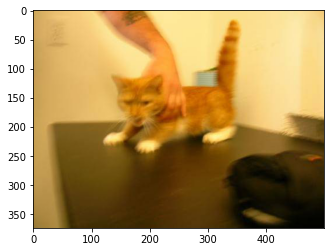

In [ ]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

print('Path: {}'.format(imagePaths[0]))
print('Class: {}'.format(labels[0]))
plt.imshow(plt.imread(imagePaths[0]))

Random state

In [ ]:
state=80

Первый базовый классификатор - бэггинг деревьев принятия решений

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              min_samples_leaf=10,
                              max_leaf_nodes=20,
                              random_state=state)
bagging = BaggingClassifier(tree,
                            n_estimators=13,
                            random_state=state)
bagging.fit(trainData, labels)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_leaf_nodes=20,
                                                        min_samples_leaf=10,
                                                        random_state=80),
                  n_estimators=13, random_state=80)

Второй базовый классификатор - метод опорных векторов (soft margin hyperplane - классификатор с мягким зазором)

In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state = state, C = 1.25)
svm.fit(trainData, labels)

LinearSVC(C=1.25, random_state=80)

Третий базовый классификатор — случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=13,
                                criterion='entropy',
                                min_samples_leaf=10,
                                max_leaf_nodes=20,
                                random_state=state)
forest.fit(trainData, labels)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=20,
                       min_samples_leaf=10, n_estimators=13, random_state=80)

Решающий метаалгоритм - логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', random_state=state)

Стекинг - обучение метаалгоритма

In [ ]:
from sklearn.ensemble import StackingClassifier

base_estimators = [('SVM', svm), ('Bagging DT', bagging), ('Decision Forest', forest)]
sclf = StackingClassifier(estimators=base_estimators, final_estimator=lr, cv=2)
sclf.fit(trainData, labels)

StackingClassifier(cv=2,
                   estimators=[('SVM', LinearSVC(C=1.25, random_state=80)),
                               ('Bagging DT',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                        max_leaf_nodes=20,
                                                                                        min_samples_leaf=10,
                                                                                        random_state=80),
                                                  n_estimators=13,
                                                  random_state=80)),
                               ('Decision Forest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_leaf_nodes=20,
                                                       min_samples_leaf=10,
         

Оценка метамодели. Доля правильной классификации (Accuracy):

In [ ]:
sclf.score(trainData, labels)

0.843

Небольшая выборка из тестового датасета

In [ ]:
test_dataset = ['test/dog.1011.jpg', 
                'test/dog.1028.jpg', 
                'test/dog.1049.jpg', 
                'test/cat.1016.jpg' ]

Предсказания для тестовых объектов



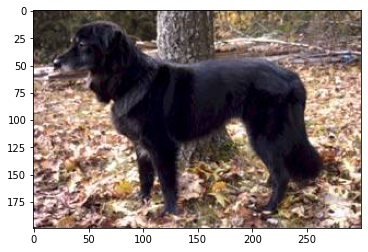

Prediction probability: [[0.41177328 0.58822672]]


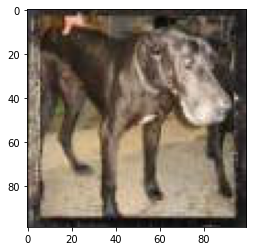

Prediction probability: [[0.71018957 0.28981043]]


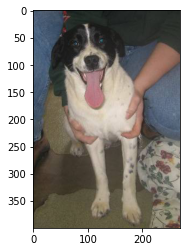

Prediction probability: [[0.59559995 0.40440005]]


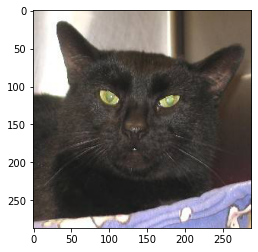

Prediction probability: [[0.70446666 0.29553334]]


In [ ]:
for item in test_dataset:
  plt.imshow(plt.imread(item))
  plt.show()
  singleImage = cv2.imread(item)
  histt = extract_histogram(singleImage).reshape(1, -1)
  prediction = sclf.predict(histt)
  prediction_proba = sclf.predict_proba(histt) # вероятности отнесения
  print('Prediction probability: {}'.format(prediction_proba))